In [1]:
# --- Import Necessary Libraries ---

# For data manipulation
import pandas as pd
import re

# For sentiment analysis model
from transformers import pipeline

# For keyword extraction (TF-IDF)
from sklearn.feature_extraction.text import TfidfVectorizer

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
sns.set_style('whitegrid')

print("All libraries imported successfully.")

All libraries imported successfully.


In [2]:
# Define the list of file paths for your CSVs
file_paths = ['ball_test.csv', 'bracelet_test.csv', 'lens_test.csv', 'ps4_controller_test.csv', 'refrigerator_test.csv'] # <--- ADD YOUR FILENAMES HERE

# Create an empty list to hold the individual DataFrames
list_of_dfs = []

print(f"Attempting to load {len(file_paths)} CSV files...")

# Loop through the list of file paths
for file_path in file_paths:
    try:
        # Load the CSV into a pandas DataFrame
        temp_df = pd.read_csv(file_path)
        
        # --- IMPORTANT: Ensure the column name is consistent ---
        # If your review column has different names in different files, rename them here.
        # For example, if some files have 'review' and others have 'review_text':
        # if 'review' in temp_df.columns:
        #     temp_df = temp_df.rename(columns={'review': 'review_text'})
        
        list_of_dfs.append(temp_df)
        print(f"  - Successfully loaded '{file_path}' ({len(temp_df)} rows)")
        
    except FileNotFoundError:
        print(f"  - Error: The file '{file_path}' was not found. It will be skipped.")
    except Exception as e:
        print(f"  - An error occurred with file '{file_path}': {e}")

# Check if any DataFrames were successfully loaded
if list_of_dfs:
    # Concatenate all the DataFrames in the list into a single DataFrame
    df = pd.concat(list_of_dfs, ignore_index=True)
    
    print("\nAll datasets combined successfully.")
    print("Shape of the final combined dataset:", df.shape)
    # Display the first 5 rows to inspect the final data
    df.head()
else:
    print("\nNo data was loaded. Please check your file paths and CSV files.")
    # Create an empty DataFrame to prevent errors in subsequent cells
    df = pd.DataFrame(columns=['review_text'])

Attempting to load 5 CSV files...
  - Successfully loaded 'ball_test.csv' (100 rows)
  - Successfully loaded 'bracelet_test.csv' (102 rows)
  - Successfully loaded 'lens_test.csv' (11 rows)
  - Successfully loaded 'ps4_controller_test.csv' (62 rows)
  - Successfully loaded 'refrigerator_test.csv' (111 rows)

All datasets combined successfully.
Shape of the final combined dataset: (386, 2)


In [3]:
# --- Step 2: Clean and Preprocess the Text Data (UPGRADED) ---

def clean_review_text(text):
    """
    Cleans the review text by removing 'READ MORE', converting to lowercase,
    and removing numbers and extra whitespace.
    """
    if not isinstance(text, str):
        return ""
    
    text = text.replace('READ MORE', '')
    
    # --- MODIFICATION HERE ---
    # Use regex to remove all digits
    text = re.sub(r'\d+', '', text)
    
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply the updated cleaning function to the 'review_text' column
df['cleaned_review'] = df['review_text'].apply(clean_review_text)

print("Text data has been cleaned with the upgraded function.")
df[['review_text', 'cleaned_review']].head()

Text data has been cleaned.


,review_text,cleaned_review
0,Good,good
1,Good,good
2,Usefull for overloading the hand,usefull for overloading the hand
3,Good product,good product
4,Good,good


In [4]:
# --- Step 3: Load the Sentiment Analysis Model ---

print("Loading the pre-trained sentiment analysis model...")
print("This may take a few minutes on the first run as the model is downloaded.")

try:
    # Load the pipeline for sentiment analysis using a specific pre-trained model
    sentiment_classifier = pipeline(
        "sentiment-analysis",
        model="bareeraqrsh/Sentiment-analysis-tool"
    )
    print("Sentiment analysis model loaded successfully.")
except Exception as e:
    print(f"An error occurred while loading the model: {e}")
    print("Please ensure you have an active internet connection.")

Loading the pre-trained sentiment analysis model...
This may take a few minutes on the first run as the model is downloaded.


Device set to use cpu


Sentiment analysis model loaded successfully.


In [5]:
# --- Step 4: Apply the Model and Map Labels ---

print("Applying sentiment analysis model to the dataset...")

# Get the sentiment for each review
results = sentiment_classifier(df['cleaned_review'].tolist())

# Extract the raw label and score from the results
df['sentiment_label'] = [result['label'] for result in results]
df['sentiment_score'] = [result['score'] for result in results]

# --- !!! THIS IS THE FIX: A MAPPING STEP !!! ---
# Define the mapping from the model's output to our desired labels
label_mapping = {
    'LABEL_2': 'POSITIVE',
    'LABEL_1': 'NEUTRAL',
    'LABEL_0': 'NEGATIVE'
}

# Apply the mapping to the 'sentiment_label' column
df['sentiment_label'] = df['sentiment_label'].map(label_mapping)

print("Sentiment analysis complete and labels have been mapped.")
# Display the reviews with their new, readable sentiments
df[['cleaned_review', 'sentiment_label', 'sentiment_score']].head()

Applying sentiment analysis model to the dataset...
Sentiment analysis complete and labels have been mapped.


,cleaned_review,sentiment_label,sentiment_score
0,good,POSITIVE,0.741096
1,good,POSITIVE,0.741096
2,usefull for overloading the hand,POSITIVE,0.918868
3,good product,POSITIVE,0.904153
4,good,POSITIVE,0.741096


In [6]:
# --- Step 5: Extract Top Keywords (UPGRADED with N-grams) ---

def get_top_keywords(df, sentiment, n_top=10):
    """
    Extracts the top N keywords/phrases for a given sentiment using TF-IDF.
    Now considers both single words and pairs of words (n-grams).
    """
    subset_df = df[df['sentiment_label'] == sentiment]
    
    if subset_df.empty:
        return []
        
    text_corpus = subset_df['cleaned_review'].tolist()
    
    # --- MODIFICATION HERE ---
    # ngram_range=(1, 2) tells the vectorizer to consider both single words (unigrams)
    # and pairs of words (bigrams).
    vectorizer = TfidfVectorizer(stop_words='english', max_features=1000, ngram_range=(1, 2))
    
    tfidf_matrix = vectorizer.fit_transform(text_corpus)
    feature_names = vectorizer.get_feature_names_out()
    summed_tfidf = tfidf_matrix.sum(axis=0)
    
    # The rest of the function remains the same...
    tfidf_scores = []
    # Note: Looping through .vocabulary_.items() can be slow on huge datasets,
    # but is fine for this size.
    for word, idx in vectorizer.vocabulary_.items():
        tfidf_scores.append((word, summed_tfidf[0, idx]))
        
    sorted_scores = sorted(tfidf_scores, key=lambda x: x[1], reverse=True)
    top_keywords = [word for word, score in sorted_scores[:n_top]]
    
    return top_keywords

# Get top 10 positive and negative keywords/phrases
top_positive_keywords = get_top_keywords(df, 'POSITIVE')
top_negative_keywords = get_top_keywords(df, 'NEGATIVE')

print("Top Positive Keywords/Phrases:", top_positive_keywords)
print("Top Negative Keywords/Phrases:", top_negative_keywords)

Top Positive Keywords: ['good', 'product', 'nice', 'quality', 'best', 'great', 'price', '5very', 'like', 'amazing']
Top Negative Keywords: ['bad', 'working', 'good', 'quality', 'product', 'don', '4fabulous', '1worthless', 'nice', 'buy']


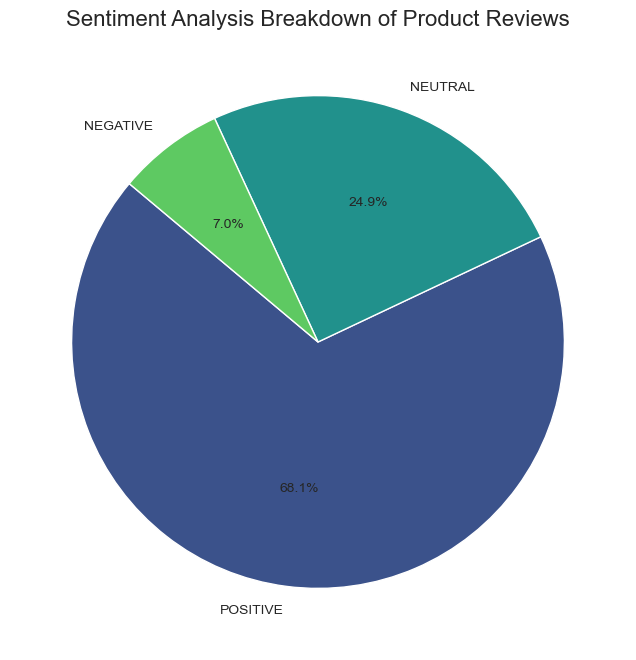


--- Summary ---
Total Reviews Analyzed: 386

Sentiment Distribution:
sentiment_label
POSITIVE    263
NEUTRAL      96
NEGATIVE     27
Name: count, dtype: int64

----------------------------------
Top 10 Keywords in POSITIVE Reviews:
good , product , nice , quality , best , great , price , 5very , like , amazing

Top 10 Keywords in NEGATIVE Reviews:
bad , working , good , quality , product , don , 4fabulous , 1worthless , nice , buy
----------------------------------


In [7]:
# --- Step 6: Generate the Summary Dashboard ---

# 1. Calculate sentiment counts
sentiment_counts = df['sentiment_label'].value_counts()

# 2. Create the Pie Chart
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("viridis", len(sentiment_counts)))
plt.title('Sentiment Analysis Breakdown of Product Reviews', fontsize=16)
plt.ylabel('') # Hides the 'sentiment_label' text on the y-axis
plt.show()

# 3. Display the Top Keywords
print("\n--- Summary ---")
print(f"Total Reviews Analyzed: {len(df)}")
print("\nSentiment Distribution:")
print(sentiment_counts)
print("\n----------------------------------")
print("Top 10 Keywords in POSITIVE Reviews:")
print(" , ".join(top_positive_keywords))
print("\nTop 10 Keywords in NEGATIVE Reviews:")
print(" , ".join(top_negative_keywords))
print("----------------------------------")